In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
import os

## Hyperparameters

In [2]:
batch_size = 128
epochs = 1250
learning_rate = 1e-4
z_dim = 15
beta1 = 0.9
beta2 = 0.99

early_stopping = True
patience = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataload

Image batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


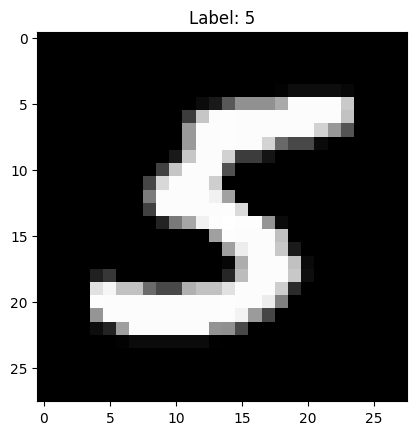

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Image batch shape:", images.shape)
print("Labels batch shape:", labels.shape)

plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

## Model 

In [4]:
class VAE(nn.Module):
    def __init__(self, z_dim = 15):
        super().__init__()

        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), # 32 14 14
            nn.ReLU(),

            nn.Conv2d(32, 64, 4, 2, 1), # 64 7 7 
            nn.ReLU(),

            nn.Conv2d(64, 128, 4, 2, 1), # 128 3 3
            nn.ReLU(),

            nn.Conv2d(128, 256, 4, 2, 1), # 256 1 1
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, self.z_dim*2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.z_dim, 256 * 1 * 1), # 256
            nn.Unflatten(1, (256, 1, 1)), # 256 1 1
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 3), # 128 3 3
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 5, 2, 1), # 64 7 7 
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 14 14
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, 4, 2, 1), # 1 28 28
        )

    def forward(self, X):
        encoded = self.encoder(X)

        z_mean = encoded[:, :self.z_dim]
        z_logvar = encoded[:, self.z_dim:]
        
        def reparametrize(mu, logvar):
            std = logvar.div(2).exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return mu + std*eps
        
        z = reparametrize(z_mean, z_logvar)
        
        decoded = self.decoder(z)
        return decoded, z_mean, z_logvar

model = VAE(z_dim=z_dim).to(device)
summary(model, (1, 28, 28))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          32,832
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 3, 3]         131,200
              ReLU-6            [-1, 128, 3, 3]               0
            Conv2d-7            [-1, 256, 1, 1]         524,544
              ReLU-8            [-1, 256, 1, 1]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                   [-1, 30]           7,710
           Linear-11                  [-1, 256]           4,096
        Unflatten-12            [-1, 256, 1, 1]               0
             ReLU-13            [-1, 256, 1, 1]               0
  ConvTranspose2d-14            [-1, 12

In [ ]:
def train():
    early_count = 0
    prev_loss = float('inf')
    model.train()
    avg_loss_per_epoch = []
    avg_kld_per_epoch = []

    for epoch in range(epochs):
        total_loss = 0
        total_kld = 0
        
        for images, _ in train_loader:
            images = images.to(device)
            recon_images, mu, logvar = model(images)

            # Reconstruction Loss (Binary Cross Entropy)
            recon_loss = F.binary_cross_entropy_with_logits(recon_images, images, reduction='sum')
            
            # KL Divergence Loss
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            total_kld += kl_divergence.item()

            # Total Loss with Beta weighting
            loss = recon_loss + kl_divergence

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()


        avg_loss = total_loss / len(train_loader.dataset)
        avg_kld = total_kld / len(train_loader.dataset)
        avg_loss_per_epoch.append(avg_loss)
        avg_kld_per_epoch.append(avg_kld)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, KLD: {avg_kld:.4f}")

        if early_stopping:
            if avg_loss > prev_loss:
                early_count += 1
            else:
                early_count = 0
            prev_loss = avg_loss
            if early_count > patience:
                print("\nEarly stopping triggered.")
                break

    return avg_loss_per_epoch, avg_kld_per_epoch

loss, kld = train()

plt.plot(loss, label='Reconstruction Loss')
plt.plot(kld, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs KL Divergence Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Epoch [1/1250], Loss: 252.1546, KLD: 3.5839
Epoch [2/1250], Loss: 172.8353, KLD: 7.0445
Epoch [3/1250], Loss: 148.2047, KLD: 11.7907
Epoch [4/1250], Loss: 137.2142, KLD: 13.1909
Epoch [5/1250], Loss: 128.8477, KLD: 14.8412
Epoch [6/1250], Loss: 122.6791, KLD: 16.1017
Epoch [7/1250], Loss: 118.6377, KLD: 16.9068
Epoch [8/1250], Loss: 115.8425, KLD: 17.3739
Epoch [9/1250], Loss: 113.6380, KLD: 17.9253
Epoch [10/1250], Loss: 111.8350, KLD: 18.4298
Epoch [11/1250], Loss: 110.3676, KLD: 18.8330
Epoch [12/1250], Loss: 109.2327, KLD: 19.1119
Epoch [13/1250], Loss: 108.2671, KLD: 19.2980
Epoch [14/1250], Loss: 107.3990, KLD: 19.4782
Epoch [15/1250], Loss: 106.6614, KLD: 19.6076
Epoch [16/1250], Loss: 106.0183, KLD: 19.7258
Epoch [17/1250], Loss: 105.4390, KLD: 19.8393
Epoch [18/1250], Loss: 104.9245, KLD: 19.9671
Epoch [19/1250], Loss: 104.3880, KLD: 20.0808
Epoch [20/1250], Loss: 103.8872, KLD: 20.1833
Epoch [21/1250], Loss: 103.3889, KLD: 20.3794
Epoch [22/1250], Loss: 102.8814, KLD: 20.6024

## Save Model

In [ ]:
os.makedirs('model', exist_ok=True)
model_path = 'model/model.pth'
torch.save(model.state_dict(), model_path)

## Generate Image

/tmp/ipykernel_197794/2733244006.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(model_path))


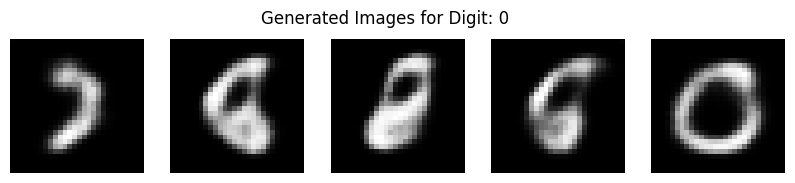

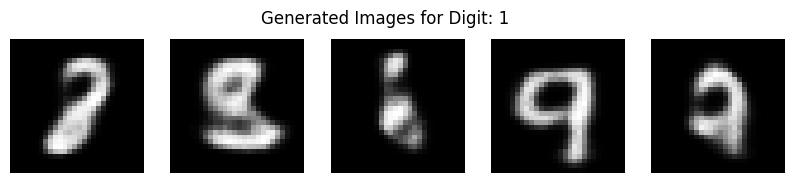

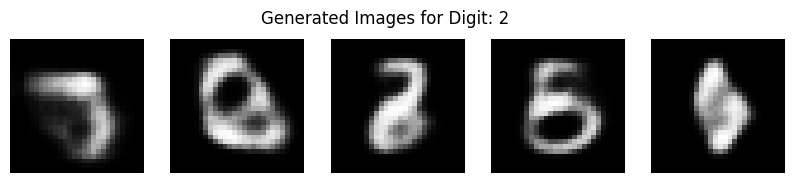

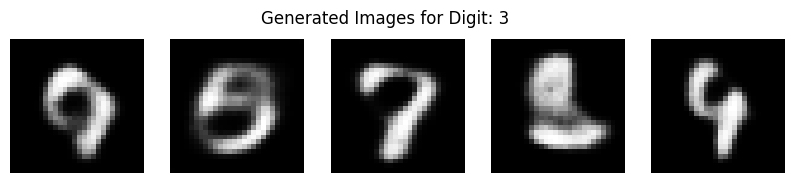

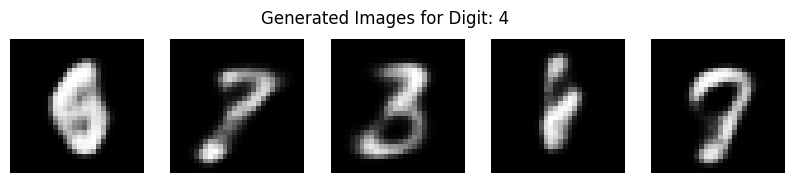

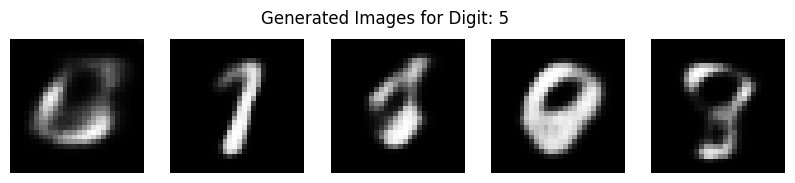

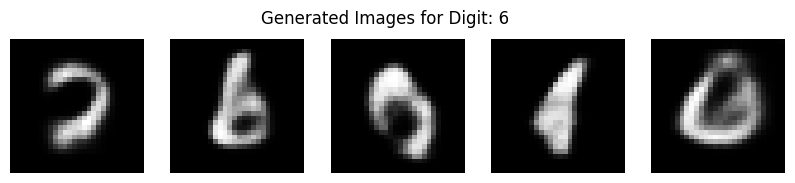

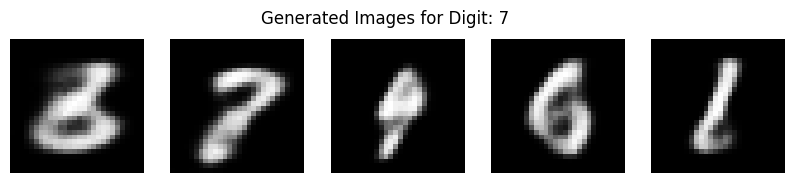

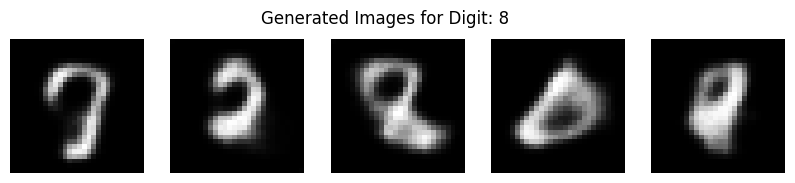

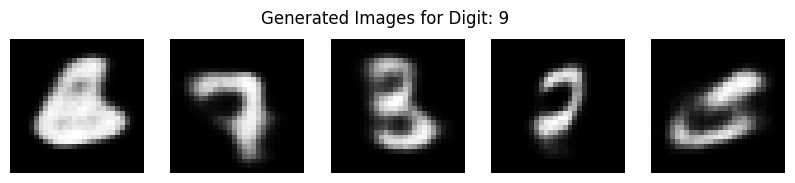

In [ ]:
def generate_images(model, z_dim=15):
    model.eval()
    with torch.no_grad():
        for digit in range(10):
            plt.figure(figsize=(10, 2))
            for i in range(5):
                # Generate latent variable from a truncated Gaussian
                z = torch.randn(1, z_dim).to(device).clamp(-2, 2)
                generated_img = torch.sigmoid(model.decoder(z))
                generated_img = generated_img.view(28, 28).cpu().numpy()
                
                plt.subplot(1, 5, i + 1)
                plt.imshow(generated_img, cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Generated Images for Digit: {digit}')
            plt.show()

# Load the saved model and generate images
test_model = VAE().to(device)
test_model.load_state_dict(torch.load(model_path))
generate_images(test_model)